## In this notebook, we'll create scripts to help run several transfer learning model experiments with different hyperparameters.

In [ ]:
"""
Create the going_modular folder and move in its scripts.
"""
import os

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular import data_setup, engine
  print("going_modular scripts already downloaded.")
except:
  """
  This block attempts to download a GitHub repository,
  move a specific directory from the downloaded repository to the current working directory,
  and then remove the downloaded repository.
  """
  # Get the going_modular scripts
  print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")

  # Clone the git repository
  os.system('git clone https://github.com/lanehale/pytorch-deep-learning')

  # When cloning a GitHub repository, the directory structure on your local machine doesn't include /tree/main/, so it shouldn't be included in the mv command.
  # The . at the end of the command tells mv to move the specified directory into the current working directory.
  !mv pytorch-deep-learning/going_modular .

  # remove the downloaded repository
  !rm -rf pytorch-deep-learning

  # move these two files out to parent directory
  !mv going_modular/train.py .
  !mv going_modular/predict.py .

  from going_modular import data_setup, engine

print(">!ls")
!ls
print(">!ls going_modular")
!ls going_modular

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
>!ls
going_modular  predict.py  sample_data	train.py
>!ls going_modular
data_setup.py  get_custom_data.py  model_builder.py  utils.py
engine.py      get_data.py	   __pycache__


In [ ]:
%%writefile going_modular/get_any_data.py
"""
Contains functionality for creating data folders and downloading from any specified data path.
"""
import os
import subprocess
import requests
import zipfile
from pathlib import Path

def from_path(from_path: str,         # e.g. "pizza_steak_sushi_20_percent.zip"
              image_dir: str):        # e.g. "pizza_steak_sushi"
  # Set up path to data folder
  data_path = Path("data/")
  image_path = data_path / image_dir  # "pizza_steak_sushi"

  # If the image folder doesn't exist, download it and prepare it...
  if image_path.is_dir():
    print(f"{image_path} directory exists.")
  else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download images
    with open(data_path / from_path, "wb") as f:   # "pizza_steak_sushi_20_percent.zip"
      #url = Path("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/") / from_path  # Path removes extra slash
      url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/" + from_path
      request = requests.get(url)
      print(f"Downloading {image_dir} data...")    # pizza, steak, sushi
      f.write(request.content)

    # Unzip image data
    with zipfile.ZipFile(data_path / from_path, "r") as zip_ref:  # "pizza_steak_sushi_20_percent.zip"
      print(f"Unzipping {image_dir} data...")      # pizza, steak, sushi
      zip_ref.extractall(image_path)

    # Remove zip file
    os.remove(data_path / from_path)  # "pizza_steak_sushi_20_percent.zip"

  # For some reason os.system('any linux cmd') commands aren't working in this function, have to use popen or subprocess instead
  print(f">!ls {image_path}")
  cmd = f"ls {image_path}"  # "ls data/pizza_steak_sushi"
  output = os.popen(cmd).read()
  print(output)

  """ These all work as well """
  #output = subprocess.check_output(cmd, shell=True).decode("utf-8")
  #print(output)

  #cmd = f"ls {image_path}/*"
  #output = os.popen(cmd).read()    # "ls data/pizza_steak_sushi/*" lists test and train contents
  #print(output)

  #cmd = f"ls {image_path}/test/*"  # "ls data/pizza_steak_sushi/test/*" lists all content of all test subfolders
  #cmd = f"ls {image_path}/test/*"  # "ls data/pizza_steak_sushi/*/*"    lists all content of all test and train subfolders
  #output = subprocess.check_output(cmd, shell=True).decode("utf-8")
  #print(output)

Writing going_modular/get_any_data.py


In [ ]:
from going_modular import get_any_data

get_any_data.from_path(from_path="pizza_steak_sushi_20_percent.zip", image_dir="pizza_steak_sushi")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza_steak_sushi data...
>!ls data/pizza_steak_sushi
test
train



In [ ]:
%%writefile going_modular/pretrained.py
"""
Contains various functions for using pretrained models (transfer learning) to train and predict on new datasets.
"""
import os
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from going_modular import data_setup, engine
from tqdm.auto import tqdm

# See if torchmetrics exists, if not, install it
try:
  import torchmetrics, mlxtend
except:
  print("Installing torchmetrics...")
  os.system('pip install -q torchmetrics -U mlxtend')
  import torchmetrics, mlxtend

# Import specific functionalities from torchmetrics and mlxtend
from torchmetrics.classification import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


"""
Contains a function to make predictions on test data.
"""
# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def predict_and_store(model, test_paths, tranform, class_names, device):
  pred_list = []
  test_preds = []
  for path in test_paths:
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Save sample path
    pred_dict["image_path"] = path

    # Save class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Save prediction and pred prob
    from PIL import Image
    img = Image.open(path)
    transformed_image = tranform(img).unsqueeze(dim=0).to(device)  # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]       # or can replace .cpu()] with .item

      pred_dict["pred_prob"] = pred_prob.max().item()  # get the highest pred_prob
      pred_dict["pred_class"] = pred_class             # predicted class name

      test_preds.append(pred_label.cpu())

    # Does the prediction match the true label?
    pred_dict["correct"] = class_name == pred_class

    # Add sample dict to list of preds
    pred_list.append(pred_dict)

    test_preds_tensor = torch.cat(test_preds)

  return pred_list, test_preds_tensor


"""
Contains a function to run data through torchvision models,
display a confusion matrix, predict, store and return results.
"""
def run_model(model,
              weights,
              train_dir,
              test_dir,
              batch_size,
              dropout,
              in_features,
              optimizer_type,
              optimizer_lr,
              num_epochs,
              image_data,
              device):

  auto_transforms = weights.transforms()

  # Create training and testing DataLoaders and get a list of class names
  train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
      train_dir=train_dir,
      test_dir=test_dir,
      transform=auto_transforms,  # perform the same data transforms on our training data as the pretrained model
      batch_size=batch_size
  )

  # Freeze all base layers in the "features" section of the model
  for parm in model.features.parameters():
    parm.requires_grad = False

  """ Adjust the output layer or the classifier portion of our pretrained model to our needs (out_features=3). """
  # Set manual seeds
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

  # Get the length of class_names (one output unit for each class)
  output_shape = len(class_names)

  # Recreate the classifier layer and seed it to the target device
  model.classifier = torch.nn.Sequential(
      torch.nn.Dropout(p=dropout, inplace=True),
      torch.nn.Linear(in_features=in_features,
                      out_features=output_shape,  # same number of output units as number of classes
                      bias=True)).to(device)

  # Define loss and optimizer
  loss_fn = nn.CrossEntropyLoss()
  if optimizer_type == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=optimizer_lr)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=optimizer_lr)

  """ Train the model """
  # Start the timer
  from timeit import default_timer as timer
  start_time = timer()

  """ Note: We're only going to be training the parameters classifier here as all of the other parameters in our model have been frozen. """
  # Set up training and save the results
  print(f"Training the model...")
  results = engine.train(model=model,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=num_epochs,
                         device=device)

  # End the timer and print out how long it took
  end_time = timer()
  print(f"[INFO] Total running time: {end_time - start_time:.3f} seconds")

  # Make predictions and store in a list of dictionaries
  print("Predicting with image_data...")
  pred_list, test_preds_tensor = predict_and_store(
      model=model,
      test_paths=image_data,
      tranform=auto_transforms,
      class_names=class_names,
      device=device
  )

  # Setup confusion matrix instance and compare predictions to targets
  confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

  # Get truth labels for test dataset
  test_truth = torch.cat([y for X, y in test_dataloader])

  confmat_tensor = confmat(preds=test_preds_tensor,
                           target=test_truth)

  # Plot the confusion matrix
  fig, ax = plot_confusion_matrix(
      conf_mat=confmat_tensor.numpy(),
      class_names=class_names,
      figsize=(10, 7)
  );

  print(f"Max test acc: {max(results['test_acc']):.3f} | Min test loss: {min(results['test_loss']):.3f}")

  return results, pred_list


"""
Contains functionality to plot the N most wrong predictions.
"""
def plot_N_most_wrong(pred_list, n):

  # Sort the list of dictionaries, False elements first, pred_prob high to low
  sorted_pred_list = sorted(pred_list, key=lambda x: (x['correct']==False, x['pred_prob']), reverse=True)

  # Turn sorted list into a DataFrame of top 5 wrong
  test_pred_df = pd.DataFrame(sorted_pred_list[:n])

  # Plot the 5 most wrong images
  for row in test_pred_df.iterrows():
    row = row[1]
    image_path = row["image_path"]
    true_label = row["class_name"]
    pred_class = row["pred_class"]
    pred_prob = row["pred_prob"]

    img = torchvision.io.read_image(str(image_path)).permute(1, 2, 0)  # get image as tensor and permute to [height, width, color_channels]
    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.4f}")
    plt.axis(False)
    plt.show()

Writing going_modular/pretrained.py


Training the model...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9514 | train_acc: 0.5979 | test_loss: 0.6660 | test_acc: 0.8568
[INFO] Total running time: 5.191 seconds
Predicting with image_data...
Max test acc: 0.857 | Min test loss: 0.666


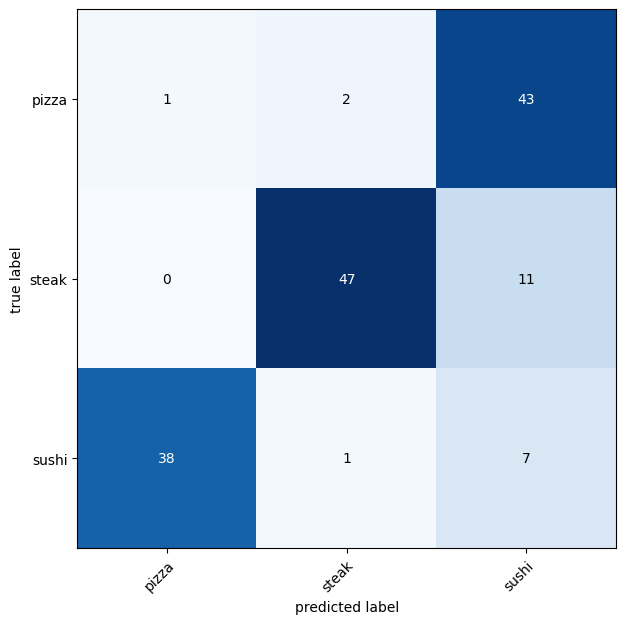

In [ ]:
import torch
import torchvision

from going_modular import pretrained
from pathlib import Path

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

image_path = Path("data/pizza_steak_sushi")

# Set up dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # .DEFAULT = best available weights from pretraining on ImageNet

# Set up the model with pretrained weights and send it to the target device (torchvision v0.13+)
model_b0 = torchvision.models.efficientnet_b0(weights=weights).to(device)

BATCH_SIZE = 32
dropout = 0.2
in_features = 1280
optimizer_type = "Adam"
optimizer_lr = 0.001
NUM_EPOCHS = 1

results_0, pred_list_0 = pretrained.run_model(
    model=model_b0,
    weights=weights,
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    dropout=dropout,
    in_features=in_features,
    optimizer_type=optimizer_type,
    optimizer_lr=optimizer_lr,
    num_epochs=NUM_EPOCHS,
    image_data=test_image_path_list,
    device=device
)

In [ ]:
false_count = 0
for pred in pred_list_0:
  if pred['correct'] == False:
    false_count += 1

false_percent = 100 * false_count / len(pred_list_0)
print(f"False predictions: {false_count} out of {len(pred_list_0)}, or {false_percent:.2f}% wrong")
print(f"True predictions: {(100.0 - false_percent):.2f}% right")

False predictions: 22 out of 150, or 14.67% wrong
True predictions: 85.33% right


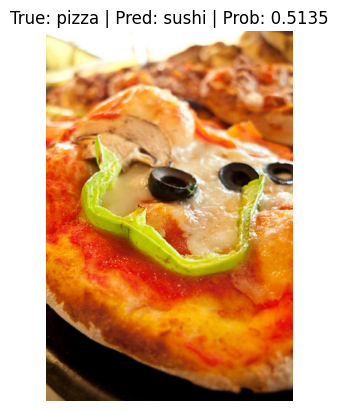

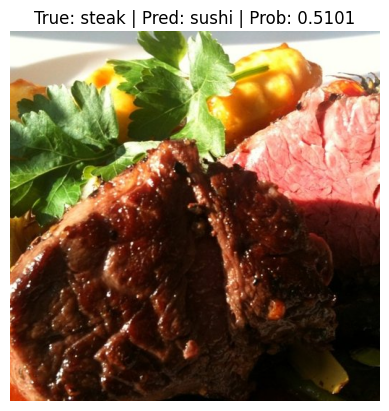

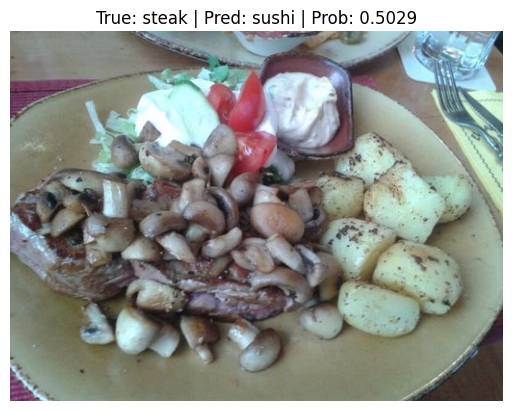

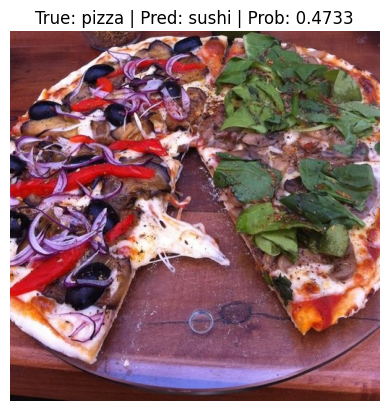

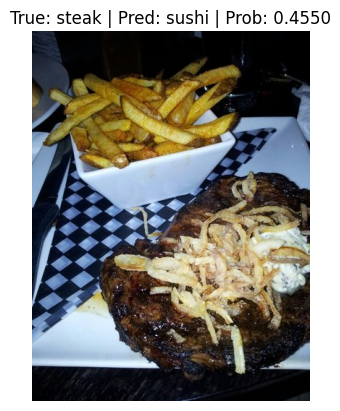

In [ ]:
if false_count < 5:
  n = false_count
else:
  n = 5

pretrained.plot_N_most_wrong(pred_list_0, n)